In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import PredefinedSplit
import scipy.stats as stats

In [16]:
# BUILD MODEL PIPELINE

# lists to store results for multiple models
all_test_scores = {}
all_best_models = {}
all_best_r2 = {}
all_best_X_train_val = {}
all_best_y_train_val = {}
all_best_X_test = {}
all_best_y_test = {}
all_best_y_pred = {}
all_best_results = {}


# function for pipeline
def MLpipe_Strat_RMSE(X, y, preprocessor, ML_algo, param_grid, random_states):
    
    best_models = [] # store best models for each random state
    test_scores = [] # store best models' RMSE test scores for each random state
    r2_scores = [] # store r^2 values for each best model
    preprocessors = [] # store preprocessors
    X_test_list = [] # store X test sets from each random state
    y_test_list = []  # store y test sets from each random state
    X_train_list = [] # store X train + val sets from each random state
    y_train_list = []  # store y train + val sets from each random state
    y_test_pred_list = [] # store y predictions from each random state 
    results_list = [] # store full model results from each random state

    # test if the input algo accepts random state or max_iter arguments
    for i in range(random_states): 
        
        try:
            ML_algo_instance = ML_algo(random_state=i)
        except TypeError:
            ML_algo_instance = ML_algo

        if 'max_iter' in ML_algo_instance.get_params():
            try:
                ML_algo.set_params(max_iter=1000000)
            except (TypeError, ValueError):
                pass

        # split out 20% of data for test, then do stratified kfold on decile bins
        q = 10
        skf_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=i).split(X, pd.qcut(y, q=q).cat.codes)
        train_index, test_index = list(skf_test)[0] # taking the first iteration of the 5 folds to make test
        X_train, y_train = X.iloc[train_index], y.iloc[train_index] # train is train + val
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        skf_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=i).split(X_train, pd.qcut(y_train, q=q).cat.codes)

        # plot distribution for train and test sets, if interested
        # bins = np.linspace(0, 40, 21)
        # plt.hist(y_train, alpha=0.5, bins=bins, density=True)
        # plt.hist(y_test, alpha=0.5, bins=bins, density=True)
        # plt.show()
        
        # preprocess the sets and fit model with inputs
        pipe = make_pipeline(preprocessor, ML_algo)

        # search over specified parameter values
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_root_mean_squared_error', 
                            return_train_score=True, n_jobs=-1, cv=skf_val,  
                            verbose=True)

        grid.fit(X_train, y_train)

        # save preprocessor so I can double check the preprocessed sets later
        num_pipeline = grid.best_estimator_.named_steps['columntransformer'].named_transformers_['num_pipeline']
        preprocess_poly = num_pipeline.named_steps['poly_features']
        preprocess_scaler = num_pipeline.named_steps['scaler']
        preprocessors.append((preprocess_poly, preprocess_scaler))
        
        # access and save results, best models, and scores
        results = pd.DataFrame(grid.cv_results_)
        y_test_pred = grid.predict(X_test)  
        best_models.append(grid.best_estimator_)
        test_scores.append(np.sqrt(mean_squared_error(y_test,y_test_pred)))
        r2_scores.append(r2_score(y_test,y_test_pred))
        results_list.append(results)

        # print best parameters and validation score over random states
        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        
        # save split sets
        X_test_list.append(X_test)
        y_test_list.append(y_test)
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        y_test_pred_list.append(y_test_pred)
   
    return test_scores, best_models, r2_scores, preprocessors, X_test_list, y_test_list, X_train_list, y_train_list, y_test_pred_list, results_list 


In [17]:
# READ IN LINEAR INTERPOLATED DATA

df = pd.read_csv("/Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/data/interpolated_data/interp1.csv")
df = df.drop(df.columns[0], axis=1)

X = df[['no_wrk_aux','no2_wrk_aux','o3_wrk_aux','temp','rh','t_since_depl']] #,'rand'
y = df['no2_ref']

random_states = 5

# the preprocessor will be applied to all columns
num_cols = X.columns

# collect all the encoders into one preprocessor
num_pipeline= Pipeline([('poly_features', PolynomialFeatures(degree=6, include_bias=False, interaction_only=True)),
                        ('scaler', StandardScaler())])

preprocessor = ColumnTransformer([("num_pipeline", num_pipeline, num_cols)])


In [18]:
# CALCULATE BASELINE RMSE AND R2 OVER RANDOM STATES

baseline_rmse = []
baseline_r2 = []

for i in range(random_states):

        # split data
        q = 10
        skf_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=i).split(X, pd.qcut(y, q=q).cat.codes)
        train_index, test_index = list(skf_test)[0] 
        X_train, y_train = X.iloc[train_index], y.iloc[train_index] 
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        # calculate baseline scores
        y_mean = np.mean(y_test)
        baseline_array = np.full_like(y_test, y_mean)
        baseline_rmse.append(np.sqrt(mean_squared_error(y_test,baseline_array)))
        baseline_r2.append(r2_score(y_test,baseline_array))
        
print("Average baseline RMSE:", np.mean(baseline_rmse, axis = 0))
print("Standard deviation of baseline RMSE:", np.std(baseline_rmse, axis = 0))
print("Average baseline R^2:", np.mean(baseline_r2, axis = 0))


Average baseline RMSE: 6.106888242072098
Standard deviation of baseline RMSE: 0.10269376012446325
Average baseline R^2: 0.0


In [19]:
# CALCULATE BASELINE HIGH TEMPERATURE RMSE OVER RANDOM STATES

baseline_high_t_rmse = []

for i in range(random_states):

        # split data
        q = 10
        skf_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=i).split(X, pd.qcut(y, q=q).cat.codes)
        train_index, test_index = list(skf_test)[0] # taking the first iteration of the 5 folds 
        X_train, y_train = X.iloc[train_index], y.iloc[train_index] # train is train + val
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        # filter for high temps
        all_test = pd.merge(X_test, y_test, left_index = True, right_index = True)
        all_high_t = all_test[all_test["temp"] > 30]
    
        # calculate baseline scores
        y_mean = np.mean(y_test)
        baseline_array = [y_mean] * len(all_high_t)
        high_t_rmse = np.sqrt(mean_squared_error(all_high_t["no2_ref"],baseline_array))
        baseline_high_t_rmse.append(high_t_rmse)

print("Average high temp baseline RMSE:", np.mean(baseline_high_t_rmse, axis = 0))


Average high temp baseline RMSE: 3.8247909262376916


In [20]:
#######################################
# MODEL TESTING
#######################################

random_states = 5

In [21]:
# LINEAR REGRESSION WITH NO REGULARIZATION

# hyperparameters to tune
param_grid_lr = {
    'linearregression__fit_intercept': [True]} 

# the model
ML_algo_lr = LinearRegression() 

# execute the pipeline
test_scores_lr, best_models_lr, r2_scores_lr, preprocessors_lr, X_test_list_lr, y_test_list_lr, X_train_list_lr, y_train_list_lr, y_test_pred_list_lr, results_list_lr = MLpipe_Strat_RMSE(
    X, y, preprocessor=preprocessor, ML_algo=ML_algo_lr, param_grid=param_grid_lr, random_states=random_states
)

# save scores 
all_test_scores['Linear Regression'] = test_scores_lr
all_best_models['Linear Regression'] = best_models_lr
all_best_r2['Linear Regression'] = r2_scores_lr
all_best_X_train_val['Linear Regression'] = X_train_list_lr
all_best_y_train_val['Linear Regression'] = y_train_list_lr
all_best_X_test['Linear Regression'] = y_test_pred_list_lr
all_best_y_test['Linear Regression'] = X_test_list_lr
all_best_y_pred['Linear Regression'] = y_test_list_lr
all_best_results['Linear Regression'] = results_list_lr

print("")
print("Model: Linear Regression")
print("Mean of test scores:", np.mean(test_scores_lr))
print("Standard deviation of test scores:", np.std(test_scores_lr))
print("Mean of test R2 values:",np.mean(r2_scores_lr))
print("Standard deviation of test R2 values:",np.std(r2_scores_lr))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'linearregression__fit_intercept': True}
validation score: -2.0732443805333594
Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'linearregression__fit_intercept': True}
validation score: -2.0902415173893028
Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'linearregression__fit_intercept': True}
validation score: -2.0743022865847434
Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'linearregression__fit_intercept': True}
validation score: -2.0929910264652714
Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {'linearregression__fit_intercept': True}
validation score: -2.0365305709028894

Model: Linear Regression
Mean of test scores: 1.983922729140899
Standard deviation of test scores: 0.04686111459770653
Mean of test R2 values: 0.8943603681600137
Standard deviation of test 

In [22]:
# MAKE SURE PREPROCESSING WORKS AND ACCESS THE PREPROCESSED FEATURE NAMES FOR LATER

# extract a pipeline
pipeline = best_models_lr[4]  

# access the ColumnTransformer
column_transformer = pipeline.named_steps['columntransformer']

# access numeric pipeline from the ColumnTransformer
num_pipeline = column_transformer.named_transformers_['num_pipeline']

# extract  preprocessors
preprocess_poly = num_pipeline.named_steps['poly_features']
preprocess_scaler = num_pipeline.named_steps['scaler']

# polynomial processing
X_test_poly = preprocess_poly.transform(X_test_list_lr[4])

# standard scaler processing
X_test_poly_scaled = preprocess_scaler.transform(X_test_poly)

print("Shape after PolynomialFeatures:", X_test_poly.shape)
print("Shape after StandardScaler:", X_test_poly_scaled.shape)

print("y_train skewness:",stats.skew(y_train_list_lr[4]))
print("y_test skewness:",stats.skew(y_test_list_lr[4]))

# access preprocessed column names
feature_names = preprocess_poly.get_feature_names_out(input_features=X.columns)


Shape after PolynomialFeatures: (1637, 63)
Shape after StandardScaler: (1637, 63)
y_train skewness: 2.162910335827434
y_test skewness: 2.209019074874324


In [23]:
# GET OUT PREPROCESSED TEST SETS AND SAVE THEM

output_dir = "/Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/data/preprocessed_data/"

for i in range(len(X_test_list_lr)):

    y_test = y_test_list_lr[i]
    
    # polynomial processing
    X_test_poly = preprocess_poly.transform(X_test_list_lr[i])

    # standard scaler processing
    X_test_poly_scaled = preprocess_scaler.transform(X_test_poly)

    # make into df
    X_test_poly_scaled_df = pd.DataFrame(X_test_poly_scaled, columns = feature_names)

    # construct file names
    X_test_filename = f"{output_dir}X_test_preprocessed_{i}.csv"
    y_test_filename = f"{output_dir}y_test_preprocessed_{i}.csv"

    # Save to the output directory
    X_test_poly_scaled_df.to_csv(X_test_filename, index=False)
    y_test.to_csv(y_test_filename, index=False)


In [24]:
# RIDGE

# hyperparameters to tune
param_grid_rdg = { 
    'ridge__alpha': [0.00001,0.0001,0.001,0.01]} 

# the model
ML_algo_rdg = Ridge() 

# execute the pipeline
test_scores_rdg, best_models_rdg, r2_scores_rdg, preprocessors_rdg, X_test_list_rdg, y_test_list_rdg, X_train_list_rdg, y_train_list_rdg, y_test_pred_list_rdg, results_list_rdg = MLpipe_Strat_RMSE(
    X, y, preprocessor=preprocessor, ML_algo=ML_algo_rdg, param_grid=param_grid_rdg, random_states=random_states
)

all_test_scores['Ridge Regression'] = test_scores_rdg
all_best_models['Ridge Regression'] = best_models_rdg
all_best_r2['Ridge Regression'] = r2_scores_rdg
all_best_X_train_val['Ridge Regression'] = X_train_list_rdg
all_best_y_train_val['Ridge Regression'] = y_train_list_rdg
all_best_X_test['Ridge Regression'] = y_test_pred_list_rdg
all_best_y_test['Ridge Regression'] = X_test_list_rdg
all_best_y_pred['Ridge Regression'] = y_test_list_rdg
all_best_results['Ridge Regression'] = results_list_rdg

print("")
print("Model: Ridge Regression")
print("Mean of test scores:", np.mean(test_scores_rdg))
print("Standard deviation of test scores:", np.std(test_scores_rdg))
print("Mean of test R2 values:",np.mean(r2_scores_rdg))
print("Standard deviation of test R2 values:",np.std(r2_scores_rdg))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
best model parameters: {'ridge__alpha': 1e-05}
validation score: -2.0732404233985564
Fitting 5 folds for each of 4 candidates, totalling 20 fits
best model parameters: {'ridge__alpha': 1e-05}
validation score: -2.090256332882808
Fitting 5 folds for each of 4 candidates, totalling 20 fits
best model parameters: {'ridge__alpha': 0.001}
validation score: -2.060016896904209
Fitting 5 folds for each of 4 candidates, totalling 20 fits
best model parameters: {'ridge__alpha': 0.0001}
validation score: -2.092190075152358
Fitting 5 folds for each of 4 candidates, totalling 20 fits
best model parameters: {'ridge__alpha': 0.0001}
validation score: -2.035794224616043

Model: Ridge Regression
Mean of test scores: 1.9819638529665968
Standard deviation of test scores: 0.047337268219495264
Mean of test R2 values: 0.894571244677201
Standard deviation of test R2 values: 0.005131662036043707


In [25]:
# RANDOM FOREST 

from sklearn.ensemble import RandomForestRegressor

# parameter grid
param_grid_rf = {
    'randomforestregressor__n_estimators': [100], # DO NOT TUNE THIS! JUST STICK WITH 100
    'randomforestregressor__max_depth': [30, 50, 100]}

# model
ML_algo_rf = RandomForestRegressor()

# execute the pipeline
test_scores_rf, best_models_rf, r2_scores_rf, preprocessors_rf, X_test_list_rf, y_test_list_rf, X_train_list_rf, y_train_list_rf, y_test_pred_list_rf, results_list_rf  = MLpipe_Strat_RMSE(
    X, y, preprocessor=preprocessor, ML_algo=ML_algo_rf, param_grid=param_grid_rf, random_states=random_states
)

all_test_scores['Random Forest'] = test_scores_rf
all_best_models['Random Forest'] = best_models_rf
all_best_r2['Random Forest'] = r2_scores_rf
all_best_X_train_val['Random Forest'] = X_train_list_rf
all_best_y_train_val['Random Forest'] = y_train_list_rf
all_best_X_test['Random Forest'] = y_test_pred_list_rf
all_best_y_test['Random Forest'] = X_test_list_rf
all_best_y_pred['Random Forest'] = y_test_list_rf
all_best_results['Random Forest'] = results_list_rf

print("")
print("Model: Random Forest")
print("Mean of test scores:", np.mean(test_scores_rf))
print("Standard deviation of test scores:", np.std(test_scores_rf))
print("Mean of test R2 values:",np.mean(r2_scores_rf))
print("Standard deviation of test R2 values:",np.std(r2_scores_rf))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'randomforestregressor__max_depth': 100, 'randomforestregressor__n_estimators': 100}
validation score: -1.5238878524092163
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'randomforestregressor__max_depth': 100, 'randomforestregressor__n_estimators': 100}
validation score: -1.5259636633246285
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'randomforestregressor__max_depth': 50, 'randomforestregressor__n_estimators': 100}
validation score: -1.5297637944923577
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'randomforestregressor__max_depth': 100, 'randomforestregressor__n_estimators': 100}
validation score: -1.531807854118366
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'randomforestregressor__max_depth': 50, 'randomforestregressor__n_estimators': 100}
valida

In [26]:
# XGBOOST

import xgboost 

# parameter grid
param_grid_xgb = {
    "xgbregressor__learning_rate": [0.1],  # low learning rate is good for smaller data set
    "xgbregressor__max_depth": [5, 15, 30], 
    "xgbregressor__reg_alpha": [1e-1, 1e0, 1e1],
    "xgbregressor__n_estimators": [10, 100, 500], 
    "xgbregressor__colsample_bytree": [0.7],
    "xgbregressor__subsample": [0.75]
}

# model
ML_algo_xgb = xgboost.XGBRegressor()

# execute the pipeline
test_scores_xgb, best_models_xgb, r2_scores_xgb, preprocessors_xgb, X_test_list_xgb, y_test_list_xgb, X_train_list_xgb, y_train_list_xgb, y_test_pred_list_xgb, results_list_xgb = MLpipe_Strat_RMSE(
    X, y, preprocessor=preprocessor, ML_algo=ML_algo_xgb, param_grid=param_grid_xgb, random_states=random_states
)

all_test_scores['XGBoost'] = test_scores_xgb
all_best_models['XGBoost'] = best_models_xgb
all_best_r2['XGBoost'] = r2_scores_xgb
all_best_X_train_val['XGBoost'] = X_train_list_xgb
all_best_y_train_val['XGBoost'] = y_train_list_xgb
all_best_X_test['XGBoost'] = y_test_pred_list_xgb
all_best_y_test['XGBoost'] = X_test_list_xgb
all_best_y_pred['XGBoost'] = y_test_list_xgb
all_best_results['XGBoost'] = results_list_xgb

print("")
print("Model: XGBoost")
print("Mean of test scores:", np.mean(test_scores_xgb))
print("Standard deviation of test scores:", np.std(test_scores_xgb))
print("Mean of test R2 values:",np.mean(r2_scores_xgb))
print("Standard deviation of test R2 values:",np.std(r2_scores_xgb))



Fitting 5 folds for each of 27 candidates, totalling 135 fits
best model parameters: {'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 500, 'xgbregressor__reg_alpha': 1.0, 'xgbregressor__subsample': 0.75}
validation score: -1.3097328189381867
Fitting 5 folds for each of 27 candidates, totalling 135 fits
best model parameters: {'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 500, 'xgbregressor__reg_alpha': 0.1, 'xgbregressor__subsample': 0.75}
validation score: -1.3110721956570708
Fitting 5 folds for each of 27 candidates, totalling 135 fits
best model parameters: {'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 500, 'xgbregressor__reg_alpha': 1.0, 'xgbregressor__subsample': 0.75}
validation score: -1.3075954823296605
Fitting 5 fol

In [27]:
# NEAREST NEIGHBOR
from sklearn.neighbors import KNeighborsRegressor

# parameter grid
param_grid_knn = {
    'kneighborsregressor__n_neighbors': [2, 3, 4, 20],
    'kneighborsregressor__weights': ["distance", "uniform"]} 

# model
ML_algo_knn = KNeighborsRegressor() # no random state

# Execute the pipeline
test_scores_knn, best_models_knn, r2_scores_knn, preprocessors_knn, X_test_list_knn, y_test_list_knn, X_train_list_knn, y_train_list_knn, y_test_pred_list_knn, results_list_knn = MLpipe_Strat_RMSE(
    X, y, preprocessor=preprocessor, ML_algo=ML_algo_knn, param_grid=param_grid_knn, random_states=random_states
) 

all_test_scores['Nearest Neighbors'] = test_scores_knn
all_best_models['Nearest Neighbors'] = best_models_knn
all_best_r2['Nearest Neighbors'] = r2_scores_knn
all_best_X_train_val['Nearest Neighbors'] = X_train_list_knn
all_best_y_train_val['Nearest Neighbors'] = y_train_list_knn
all_best_X_test['Nearest Neighbors'] = y_test_pred_list_knn
all_best_y_test['Nearest Neighbors'] = X_test_list_knn
all_best_y_pred['Nearest Neighbors'] = y_test_list_knn
all_best_results['Nearest Neighbors'] = results_list_knn

print("")
print("Model: Nearest Neighbors")
print("Mean of test scores:", np.mean(test_scores_knn))
print("Standard deviation of test scores:", np.std(test_scores_knn))
print("Mean of test R2 values:",np.mean(r2_scores_knn))
print("Standard deviation of test R2 values:",np.std(r2_scores_knn))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best model parameters: {'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}
validation score: -2.080185976898407
Fitting 5 folds for each of 8 candidates, totalling 40 fits
best model parameters: {'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}
validation score: -2.0977904779656287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
best model parameters: {'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}
validation score: -2.0545610621932986
Fitting 5 folds for each of 8 candidates, totalling 40 fits
best model parameters: {'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}
validation score: -2.093304924695571
Fitting 5 folds for each of 8 candidates, totalling 40 fits
best model parameters: {'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}
validation scor

In [28]:
####################################################################
# FEATURE IMPORTANCES
####################################################################

# access column names
feature_names = preprocess_poly.get_feature_names_out(input_features=X.columns)


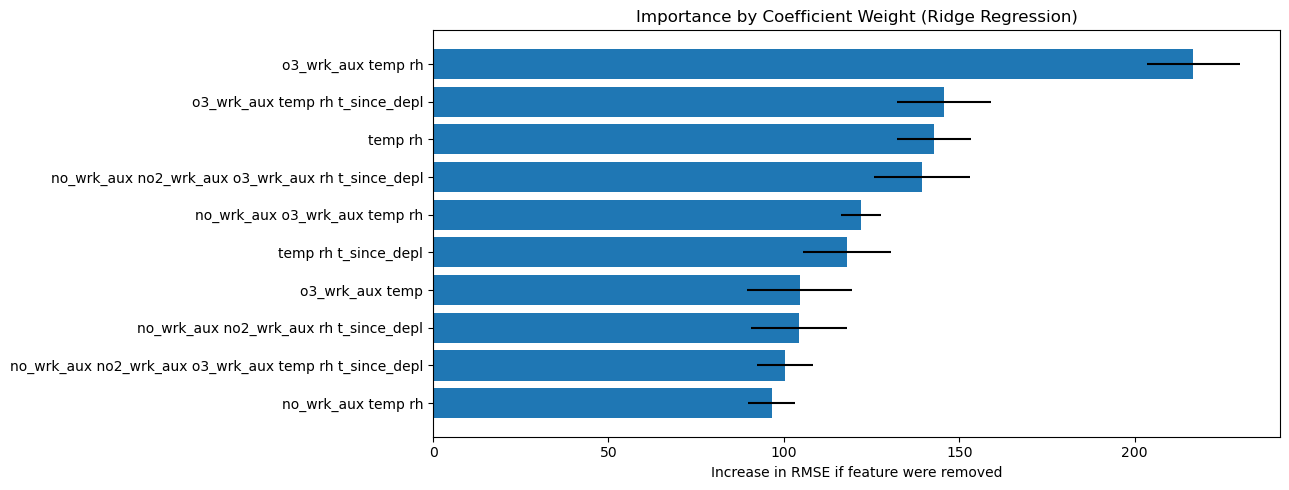

In [49]:
# GLOBAL FEATURE IMPORTANCE FOR RIDGE REGRESSION

# USING WEIGHTS

coefs_rdg = []

# access coefficients from each random state
for i in range(len(best_models_rdg)):

    pipeline = best_models_rdg[i]
    model = pipeline.named_steps['ridge'] 
    coef_rdg = model.coef_
    coefs_rdg.append(coef_rdg)

coefs_rdg_array = np.array(coefs_rdg)

# calculate averages and standard devs for each random state
avg_coefs_rdg = np.mean(np.abs(coefs_rdg_array), axis=0)
std_coefs_rdg = np.std(np.abs(coefs_rdg_array), axis=0)

# match stats with feature names
label_avg_coefs_rdg = pd.Series(avg_coefs_rdg, index=feature_names)
label_std_coefs_rdg = pd.Series(std_coefs_rdg, index=feature_names)

# find top 10
sorted_idx_rdg = label_avg_coefs_rdg.sort_values(ascending=False).index[:10]
sorted_coefs_mean_rdg = label_avg_coefs_rdg.loc[sorted_idx_rdg]
sorted_coefs_std_rdg = label_std_coefs_rdg.loc[sorted_idx_rdg]

plt.figure(figsize=(13, 5))
plt.barh(sorted_coefs_mean_rdg.index, sorted_coefs_mean_rdg.values, xerr=sorted_coefs_std_rdg.values)
plt.xlabel('Increase in RMSE if feature were removed')
plt.title('Importance by Coefficient Weight (Ridge Regression)')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('/Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/figures/feat_importance_figures/interp1_ridge_weights.png',dpi=300) 

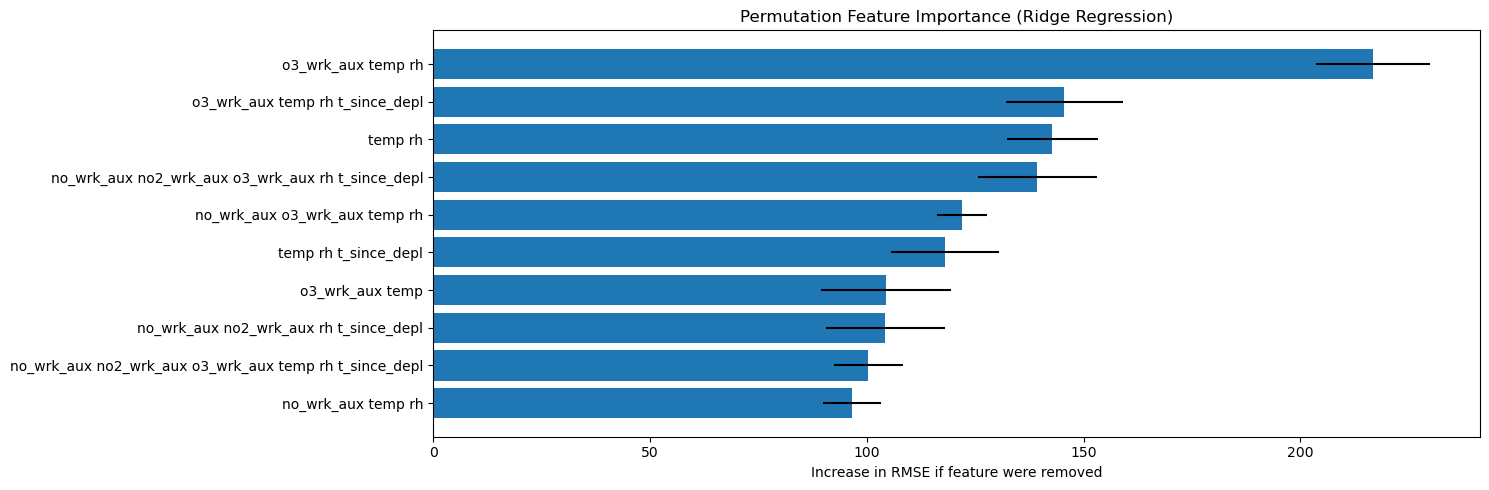

In [48]:
# GLOBAL FEATURE IMPORTANCE FOR RIDGE REGRESSION

# USING PERMUTATION IMPORTANCE

from sklearn.inspection import permutation_importance
from sklearn.metrics import root_mean_squared_error

ridge_perm_results = []

for i in range(len(best_models_rdg)):

    # access split sets across random states
    best_pipeline = best_models_rdg[i]
    X_test_rdg = X_test_list_rdg[i]
    y_test_rdg = y_test_list_rdg[i]

    model = best_pipeline.named_steps['ridge']

    # preprocess split sets across random states
    column_transformer = best_pipeline.named_steps['columntransformer']
    num_pipeline = column_transformer.named_transformers_['num_pipeline']
    preprocess_poly = num_pipeline.named_steps['poly_features']
    preprocess_scaler = num_pipeline.named_steps['scaler']
    X_test_poly = preprocess_poly.transform(X_test_rdg)
    X_test_poly_scaled = preprocess_scaler.transform(X_test_poly)

    # calculate permutation feature importance using RMSE
    ridge_perm_result = permutation_importance(model, X_test_poly_scaled, y_test_rdg, scoring = "neg_root_mean_squared_error",
                                               n_repeats=10, random_state=i)
    ridge_perm_results.append(ridge_perm_result)

# calculate mean and std importance over random states
importances_mean = np.mean([ridge_perm_result['importances_mean'] for ridge_perm_result in ridge_perm_results], axis=0)
importances_std = np.std([ridge_perm_result['importances_std'] for ridge_perm_result in ridge_perm_results], axis=0)

# match importances with feature names
label_importances_mean = pd.Series(importances_mean, index=feature_names)
label_importances_std = pd.Series(importances_std, index=feature_names)

# find top 10
sorted_idx = label_importances_mean.sort_values(ascending=False).index[:10]
sorted_importances_mean = label_importances_mean.loc[sorted_idx]
sorted_importances_std = label_importances_std.loc[sorted_idx]

plt.figure(figsize=(15, 5))
plt.barh(sorted_coefs_mean_rdg.index, sorted_coefs_mean_rdg.values, xerr=sorted_coefs_std_rdg.values)
plt.xlabel('Increase in RMSE if feature were removed')
plt.title('Permutation Feature Importance (Ridge Regression)')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('/Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/figures/feat_importance_figures/interp1_ridge_perm.png',dpi=300) 


In [31]:
# GLOBAL AND LOCAL FEATURE IMPORTANCE FOR XGBOOST

from sklearn.inspection import permutation_importance
import shap
shap.initjs() # required for visualizations

xgb_impt_results = []
X_test_poly_scaled_sets = []
explainers = []
shap_values_sets = []
xgb_totalgain_results = []

gain_scores_collection = {}


for i in range(len(best_models_xgb)):

    # access split sets across random states
    best_pipeline = best_models_xgb[i]
    X_test_xgb = X_test_list_xgb[i]
    y_test_xgb = y_test_list_xgb[i]

    # preprocess sets
    model = best_pipeline.named_steps['xgbregressor'] 
    column_transformer = best_pipeline.named_steps['columntransformer']
    num_pipeline = column_transformer.named_transformers_['num_pipeline']
    preprocess_poly = num_pipeline.named_steps['poly_features']
    preprocess_scaler = num_pipeline.named_steps['scaler']

    X_test_poly = preprocess_poly.transform(X_test_xgb)
    X_test_poly_scaled = preprocess_scaler.transform(X_test_poly)
    X_test_poly_scaled_sets.append(X_test_poly_scaled)

    # global importance with permutation_importance
    result = permutation_importance(model, X_test_poly_scaled, y_test_xgb, scoring = "neg_root_mean_squared_error", 
                                    n_repeats=10, random_state=i)
    xgb_impt_results.append(result)

    # global importance with total gain
    xgb_totalgain_score = model.get_booster().get_score(importance_type='total_gain')
    xgb_totalgain_keys = list(xgb_totalgain_score.keys())
    xgb_totalgain_values = list(xgb_totalgain_score.values())
    xgb_totalgain_df = pd.DataFrame(data=xgb_totalgain_values, index=feature_names, columns = ["score"])
    xgb_totalgain_df_idx = xgb_totalgain_df.sort_values(by = "score", ascending = False).index
    xgb_totalgain_df_sort = xgb_totalgain_df.loc[xgb_totalgain_df_idx]
    xgb_totalgain_results.append(xgb_totalgain_df_sort)

    # global and local importance with shap
    explainer = shap.TreeExplainer(model)
    explainers.append(explainer)
    shap_values = explainer.shap_values(X_test_poly_scaled) # on the preprocessed set
    shap_values_sets.append(shap_values)


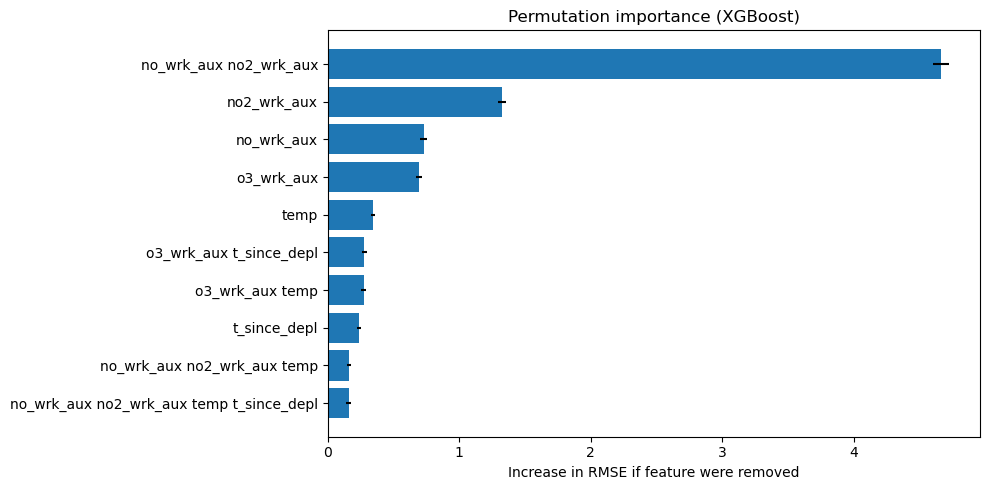

In [32]:
# XGB PERMUTATION IMPORTANCE PLOT

importances_mean = np.mean([result['importances_mean'] for result in xgb_impt_results], axis=0)
importances_std = np.mean([result['importances_std'] for result in xgb_impt_results], axis=0)

label_importances_mean = pd.Series(importances_mean, index=feature_names)
label_importances_std = pd.Series(importances_std, index=feature_names)

sorted_idx = label_importances_mean.sort_values(ascending=False).index[:10]
sorted_importances_mean = label_importances_mean.loc[sorted_idx]
sorted_importances_std = label_importances_std.loc[sorted_idx]

# Permutation importance plot
plt.figure(figsize=(10, 5))
plt.barh(sorted_importances_mean.index, sorted_importances_mean.values, xerr=sorted_importances_std.values)
plt.xlabel('Increase in RMSE if feature were removed')
plt.title('Permutation importance (XGBoost)')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('/Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/figures/feat_importance_figures/interp1_xgb_perm.png',dpi=300) 

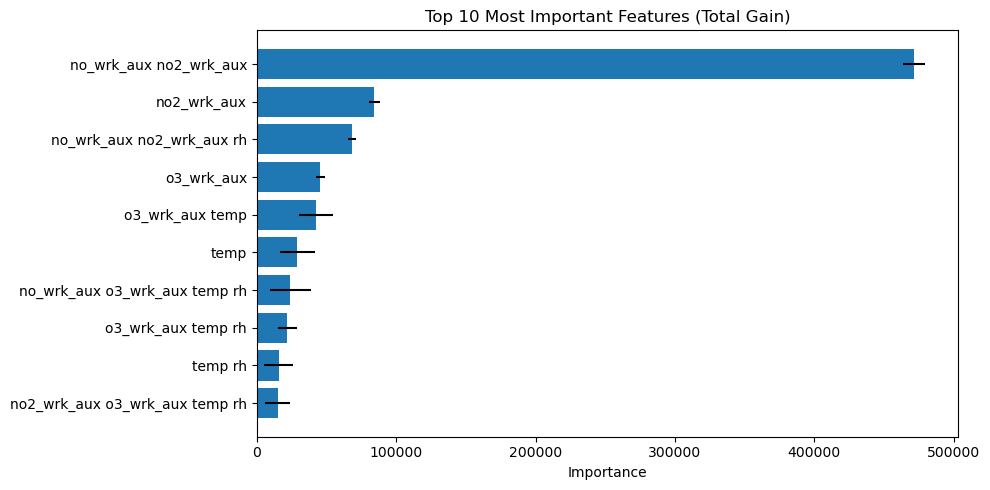

In [33]:
# XGB TOTAL GAIN PLOT

aligned_results = []

for df in xgb_totalgain_results:
    # reindex to order each result
    aligned_results.append(df.reindex(index=feature_names))

# average results
combined_results = pd.concat(aligned_results, axis=1)
xgb_totalgain_summary = combined_results.mean(axis=1)
xgb_totalgain_std = combined_results.std(axis=1)

xgb_totalgain_summary_df = pd.DataFrame(xgb_totalgain_summary, columns=['mean_score'])
xgb_totalgain_std_df = pd.DataFrame(xgb_totalgain_std, columns=['stdev_score'])

# top 10 features
sorted_idx = xgb_totalgain_summary_df.sort_values(ascending=False, by = "mean_score").index[:10]
sorted_totalgain = xgb_totalgain_summary_df.loc[sorted_idx]
sorted_std = xgb_totalgain_std_df.loc[sorted_idx]

# total Gain
plt.figure(figsize=(10, 5))
plt.barh(sorted_totalgain.index, sorted_totalgain["mean_score"], xerr = sorted_std["stdev_score"])
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features (Total Gain)')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('/Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/figures/feat_importance_figures/interp1_xgb_totalgain.png', dpi=300) 


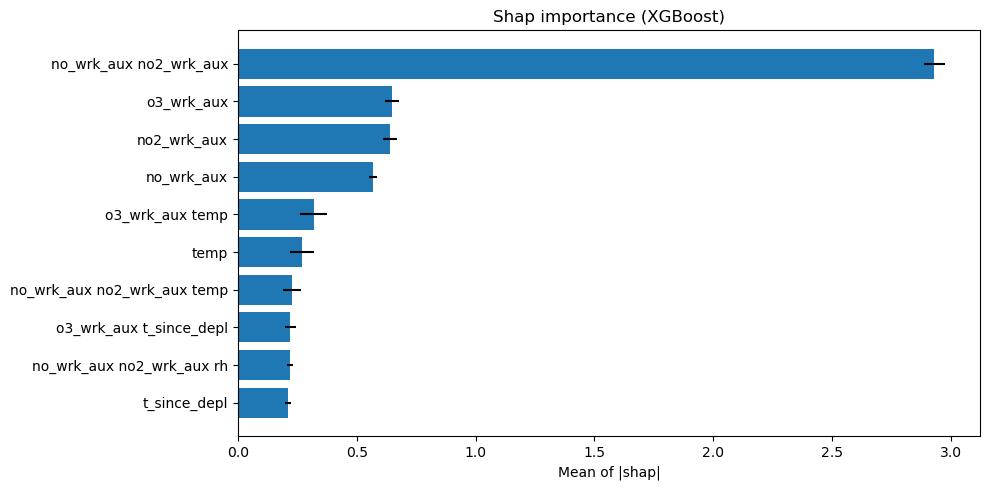

In [35]:
# XGB GLOBAL SHAP PLOT

# average across instances and random states
shap_summary_per_state = np.mean(np.abs(shap_values_sets), axis=1)
shap_global = np.mean(shap_summary_per_state, axis=0)
shap_global_std = np.std(shap_summary_per_state, axis=0)

shap_labels = pd.Series(shap_global, index=feature_names)
shap_labels_std = pd.Series(shap_global_std, index=feature_names)

shap_labels_idx = shap_labels.sort_values(ascending=False).index[:10]
shap_labels_sort = shap_labels.loc[shap_labels_idx]
shap_labels_sort_std = shap_labels_std.loc[shap_labels_idx]


# shap plot
plt.figure(figsize=(10, 5))
plt.barh(shap_labels_sort.index, shap_labels_sort.values, xerr=shap_labels_sort_std.values)
plt.xlabel('Mean of |shap|')
plt.title('Shap importance (XGBoost)')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('/Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/figures/feat_importance_figures/interp1_xgb_globalshap.png', dpi = 300) 

In [36]:
# XGBOOST LOCAL IMPORTANCES
# make local shap plots for the first three points in the first "best model"

shap_values_model_0 = shap_values_sets[0]

shap_values_model_0_idx_0 = shap_values_model_0[0,:]
shap_values_model_0_idx_1 = shap_values_model_0[1,:]
shap_values_model_0_idx_2 = shap_values_model_0[2,:]

# get explainer and features for first model
explainer_0 = explainers[0]
X_test_poly_scaled_0 = X_test_poly_scaled_sets[0]

# transform test set into df
X_test_poly_scaled_0_df = pd.DataFrame(X_test_poly_scaled_0, columns=feature_names)

# local plots
force_plot_0 = shap.force_plot(explainer_0.expected_value, shap_values_model_0_idx_0, features = X_test_poly_scaled_0_df.iloc[0,:,], feature_names = feature_names)
force_plot_1 = shap.force_plot(explainer_0.expected_value, shap_values_model_0_idx_1, features = X_test_poly_scaled_0_df.iloc[1,:], feature_names = feature_names)
force_plot_2 = shap.force_plot(explainer_0.expected_value, shap_values_model_0_idx_2, features = X_test_poly_scaled_0_df.iloc[2,:], feature_names = feature_names)

display(force_plot_0)
display(force_plot_1)
display(force_plot_2)


In [37]:
# EVALUATE MODEL PERFORMANCES UNDER HIGH TEMPERATURE CONDITIONS

# linear regression (no regulatization)

# Lists to store RMSE and R^2 values
rmse_list_lr = []
r2_list_lr = []

# Loop over each element in the lists
for i in range(len(y_test_pred_list_lr)):

    # make y_pred into a df
    y_test_pred_lr_df = pd.DataFrame(y_test_pred_list_lr[i], columns=['y_pred_lr'])

    # drop indices (resetting index for test sets)
    X_test_lr = X_test_list_lr[i].reset_index(drop=True)
    y_test_lr = y_test_list_lr[i].reset_index(drop=True)

    # concatenate sets
    ys_lr_lrs = pd.merge(y_test_lr, y_test_pred_lr_df, left_index=True, right_index=True)
    all_lr_lrs = pd.merge(X_test_lr, ys_lr_lrs, left_index=True, right_index=True)

    # isolate high temps
    all_lr_lrs_high_t = all_lr_lrs[all_lr_lrs["temp"] > 30]

    # calculate RMSE and R^2 for high temp set
    high_t_rmse_lr = np.sqrt(mean_squared_error(all_lr_lrs_high_t["no2_ref"], all_lr_lrs_high_t["y_pred_lr"]))
    high_t_r2_lr = r2_score(all_lr_lrs_high_t["no2_ref"], all_lr_lrs_high_t["y_pred_lr"])

    # Store RMSE and R^2 in the lists
    rmse_list_lr.append(high_t_rmse_lr)
    r2_list_lr.append(high_t_r2_lr)

# Calculate the average and standard deviation for RMSE and R^2
avg_rmse_lr = np.mean(rmse_list_lr)
std_rmse_lr = np.std(rmse_list_lr)

avg_r2_lr = np.mean(r2_list_lr)
std_r2_lr = np.std(r2_list_lr)

# Print the average and standard deviation for RMSE and R^2
print("Average high temp RMSE:", avg_rmse_lr)
print("Standard dev of high temp RMSE:", std_rmse_lr)

print("Average high temp R^2:", avg_r2_lr)
print("Standard dev of high temp R^2:", std_r2_lr)

Average high temp RMSE: 2.0364861541469916
Standard dev of high temp RMSE: 0.13335700179832807
Average high temp R^2: -0.22497303901896837
Standard dev of high temp R^2: 0.3227589948535249


In [38]:
# EVALUATE MODEL PERFORMANCES UNDER HIGH TEMPERATURE CONDITIONS

# Ridge regression

# Lists to store RMSE and R^2 values
rmse_list_rdg = []
r2_list_rdg = []

# Loop over each element in the lists
for i in range(len(y_test_pred_list_rdg)):

    # make y_pred into a df
    y_test_pred_rdg_df = pd.DataFrame(y_test_pred_list_rdg[i], columns=['y_pred_rdg'])

    # drop indices (resetting index for test sets)
    X_test_rdg = X_test_list_rdg[i].reset_index(drop=True)
    y_test_rdg = y_test_list_rdg[i].reset_index(drop=True)

    # concatenate sets
    ys_rdg_lrs = pd.merge(y_test_rdg, y_test_pred_rdg_df, left_index=True, right_index=True)
    all_rdg_lrs = pd.merge(X_test_rdg, ys_rdg_lrs, left_index=True, right_index=True)

    # isolate high temps
    all_rdg_lrs_high_t = all_rdg_lrs[all_rdg_lrs["temp"] > 30]

    # calculate RMSE and R^2 for high temp set
    high_t_rmse_rdg = np.sqrt(mean_squared_error(all_rdg_lrs_high_t["no2_ref"], all_rdg_lrs_high_t["y_pred_rdg"]))
    high_t_r2_rdg = r2_score(all_rdg_lrs_high_t["no2_ref"], all_rdg_lrs_high_t["y_pred_rdg"])

    # Store RMSE and R^2 in the lists
    rmse_list_rdg.append(high_t_rmse_rdg)
    r2_list_rdg.append(high_t_r2_rdg)

# Calculate the average and standard deviation for RMSE and R^2
avg_rmse_rdg = np.mean(rmse_list_rdg)
std_rmse_rdg = np.std(rmse_list_rdg)

avg_r2_rdg = np.mean(r2_list_rdg)
std_r2_rdg = np.std(r2_list_rdg)

# Print the average and standard deviation for RMSE and R^2
print("Average high temp RMSE:", avg_rmse_rdg)
print("Standard dev of high temp RMSE:", std_rmse_rdg)

print("Average high temp R^2:", avg_r2_rdg)
print("Standard dev of high temp R^2:", std_r2_rdg)

Average high temp RMSE: 2.030622594416169
Standard dev of high temp RMSE: 0.13338794086127842
Average high temp R^2: -0.2153191217056339
Standard dev of high temp R^2: 0.3075665819222827


In [39]:
# EVALUATE MODEL PERFORMANCES UNDER HIGH TEMPERATURE CONDITIONS

# Random Forest

# Lists to store RMSE and R^2 values
rmse_list_rf = []
r2_list_rf = []

# Loop over each element in the lists
for i in range(len(y_test_pred_list_rf)):

    # make y_pred into a df
    y_test_pred_rf_df = pd.DataFrame(y_test_pred_list_rf[i], columns=['y_pred_rf'])

    # drop indices (resetting index for test sets)
    X_test_rf = X_test_list_rf[i].reset_index(drop=True)
    y_test_rf = y_test_list_rf[i].reset_index(drop=True)

    # concatenate sets
    ys_rf_lrs = pd.merge(y_test_rf, y_test_pred_rf_df, left_index=True, right_index=True)
    all_rf_lrs = pd.merge(X_test_rf, ys_rf_lrs, left_index=True, right_index=True)

    # isolate high temps
    all_rf_lrs_high_t = all_rf_lrs[all_rf_lrs["temp"] > 30]

    # calculate RMSE and R^2 for high temp set
    high_t_rmse_rf = np.sqrt(mean_squared_error(all_rf_lrs_high_t["no2_ref"], all_rf_lrs_high_t["y_pred_rf"]))
    high_t_r2_rf = r2_score(all_rf_lrs_high_t["no2_ref"], all_rf_lrs_high_t["y_pred_rf"])

    # Store RMSE and R^2 in the lists
    rmse_list_rf.append(high_t_rmse_rf)
    r2_list_rf.append(high_t_r2_rf)

# Calculate the average and standard deviation for RMSE and R^2
avg_rmse_rf = np.mean(rmse_list_rf)
std_rmse_rf = np.std(rmse_list_rf)

avg_r2_rf = np.mean(r2_list_rf)
std_r2_rf = np.std(r2_list_rf)

# Print the average and standard deviation for RMSE and R^2
print("Average high temp RMSE:", avg_rmse_rf)
print("Standard dev of high temp RMSE:", std_rmse_rf)

print("Average high temp R^2:", avg_r2_rf)
print("Standard dev of high temp R^2:", std_r2_rf)

Average high temp RMSE: 1.4376377834263594
Standard dev of high temp RMSE: 0.04352176247082488
Average high temp R^2: 0.39599088740822774
Standard dev of high temp R^2: 0.11915009422749563


In [40]:
# EVALUATE MODEL PERFORMANCES UNDER HIGH TEMPERATURE CONDITIONS

# XGBoost

# Lists to store RMSE and R^2 values
rmse_list_xgb = []
r2_list_xgb = []

# Loop over each element in the lists
for i in range(len(y_test_pred_list_xgb)):

    # make y_pred into a df
    y_test_pred_xgb_df = pd.DataFrame(y_test_pred_list_xgb[i], columns=['y_pred_xgb'])

    # drop indices (resetting index for test sets)
    X_test_xgb = X_test_list_xgb[i].reset_index(drop=True)
    y_test_xgb = y_test_list_xgb[i].reset_index(drop=True)

    # concatenate sets
    ys_xgb_lrs = pd.merge(y_test_xgb, y_test_pred_xgb_df, left_index=True, right_index=True)
    all_xgb_lrs = pd.merge(X_test_xgb, ys_xgb_lrs, left_index=True, right_index=True)

    # isolate high temps
    all_xgb_lrs_high_t = all_xgb_lrs[all_xgb_lrs["temp"] > 30]

    # calculate RMSE and R^2 for high temp set
    high_t_rmse_xgb = np.sqrt(mean_squared_error(all_xgb_lrs_high_t["no2_ref"], all_xgb_lrs_high_t["y_pred_xgb"]))
    high_t_r2_xgb = r2_score(all_xgb_lrs_high_t["no2_ref"], all_xgb_lrs_high_t["y_pred_xgb"])

    # Store RMSE and R^2 in the lists
    rmse_list_xgb.append(high_t_rmse_xgb)
    r2_list_xgb.append(high_t_r2_xgb)

# Calculate the average and standard deviation for RMSE and R^2
avg_rmse_xgb = np.mean(rmse_list_xgb)
std_rmse_xgb = np.std(rmse_list_xgb)

avg_r2_xgb = np.mean(r2_list_xgb)
std_r2_xgb = np.std(r2_list_xgb)

# Print the average and standard deviation for RMSE and R^2
print("Average high temp RMSE:", avg_rmse_xgb)
print("Standard dev of high temp RMSE:", std_rmse_xgb)

print("Average high temp R^2:", avg_r2_xgb)
print("Standard dev of high temp R^2:", std_r2_xgb)

Average high temp RMSE: 1.315994934706474
Standard dev of high temp RMSE: 0.053523596136697764
Average high temp R^2: 0.49419106971047116
Standard dev of high temp R^2: 0.09573070231719523


In [41]:
# EVALUATE MODEL PERFORMANCES UNDER HIGH TEMPERATURE CONDITIONS

# K Nearest Neighbors

# Lists to store RMSE and R^2 values
rmse_list_knn = []
r2_list_knn = []

# Loop over each element in the lists
for i in range(len(y_test_pred_list_knn)):

    # make y_pred into a df
    y_test_pred_knn_df = pd.DataFrame(y_test_pred_list_knn[i], columns=['y_pred_knn'])

    # drop indices (resetting index for test sets)
    X_test_knn = X_test_list_knn[i].reset_index(drop=True)
    y_test_knn = y_test_list_knn[i].reset_index(drop=True)

    # concatenate sets
    ys_knn_lrs = pd.merge(y_test_knn, y_test_pred_knn_df, left_index=True, right_index=True)
    all_knn_lrs = pd.merge(X_test_knn, ys_knn_lrs, left_index=True, right_index=True)

    # isolate high temps
    all_knn_lrs_high_t = all_knn_lrs[all_knn_lrs["temp"] > 30]

    # calculate RMSE and R^2 for high temp set
    high_t_rmse_knn = np.sqrt(mean_squared_error(all_knn_lrs_high_t["no2_ref"], all_knn_lrs_high_t["y_pred_knn"]))
    high_t_r2_knn = r2_score(all_knn_lrs_high_t["no2_ref"], all_knn_lrs_high_t["y_pred_knn"])

    # Store RMSE and R^2 in the lists
    rmse_list_knn.append(high_t_rmse_knn)
    r2_list_knn.append(high_t_r2_knn)

# Calculate the average and standard deviation for RMSE and R^2
avg_rmse_knn = np.mean(rmse_list_knn)
std_rmse_knn = np.std(rmse_list_knn)

avg_r2_knn = np.mean(r2_list_knn)
std_r2_knn = np.std(r2_list_knn)

# Print the average and standard deviation for RMSE and R^2
print("Average high temp RMSE:", avg_rmse_knn)
print("Standard dev of high temp RMSE:", std_rmse_knn)

print("Average high temp R^2:", avg_r2_knn)
print("Standard dev of high temp R^2:", std_r2_knn)

Average high temp RMSE: 1.748004601600061
Standard dev of high temp RMSE: 0.21349095121648518
Average high temp R^2: 0.13051769291640172
Standard dev of high temp R^2: 0.08327364275896634


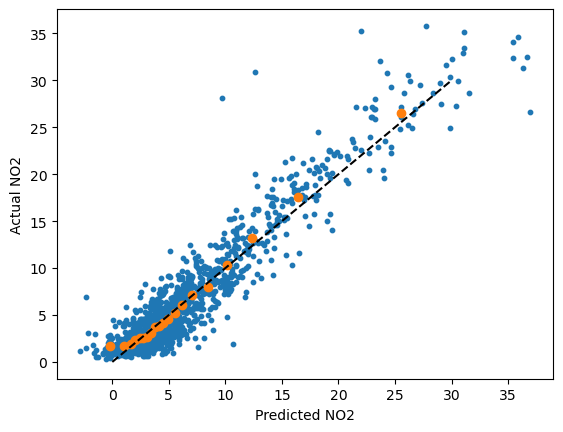

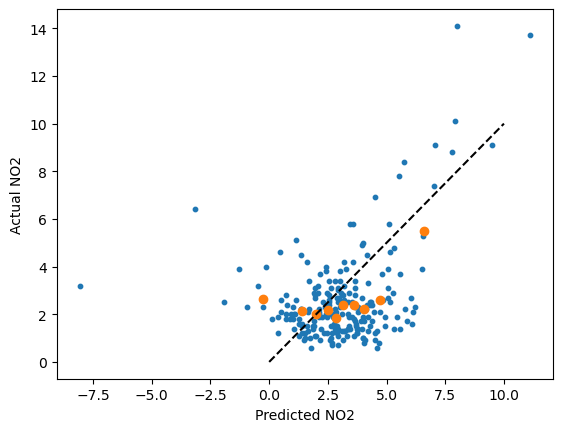

In [42]:
# PLAY AROUND WITH PLOTTING HIGH TEMPS OF RIDGE MODEL

y_pred = all_rdg_lrs.loc[all_rdg_lrs["temp"] <= 30, 'y_pred_rdg']
y_true = all_rdg_lrs.loc[all_rdg_lrs["temp"] <= 30, 'no2_ref']

cut = pd.qcut(y_pred, 20)
plt.scatter(y_pred, y_true, s=10)
plt.scatter(y_pred.groupby(cut, observed=False).mean(), y_true.groupby(cut, observed=False).mean())
plt.plot([0, 30], [0, 30], ls='--', c='k')
plt.xlabel("Predicted NO2")
plt.ylabel("Actual NO2")
plt.savefig("/Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/figures/misc_performance_figures/interp1_ridge_performance.png")
plt.show()

y_pred = all_rdg_lrs.loc[all_rdg_lrs["temp"] > 30, 'y_pred_rdg']
y_true = all_rdg_lrs.loc[all_rdg_lrs["temp"] > 30, 'no2_ref']

cut = pd.qcut(y_pred, 10)
plt.scatter(y_pred, y_true, s=10)
plt.scatter(y_pred.groupby(cut, observed=False).mean(), y_true.groupby(cut, observed=False).mean())
plt.plot([0, 10], [0, 10], ls='--', c='k')
plt.xlabel("Predicted NO2")
plt.ylabel("Actual NO2")
plt.savefig("/Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/figures/misc_performance_figures/interp1_ridge_highT_performance.png")
plt.show()

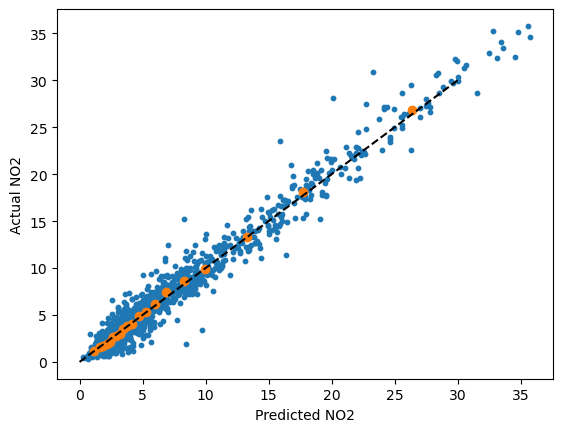

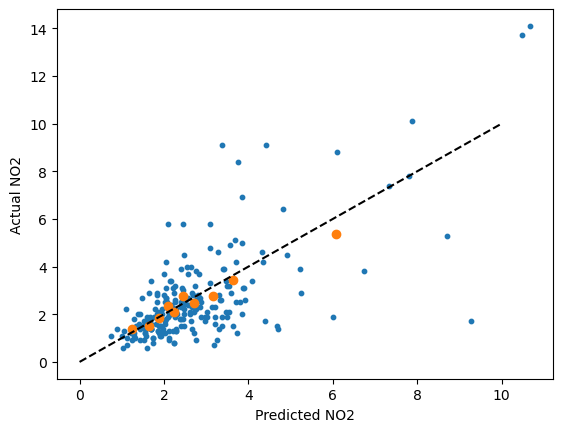

In [43]:
# PLAY AROUND WITH PLOTTING HIGH TEMPS OF RIDGE MODEL

y_pred = all_xgb_lrs.loc[all_xgb_lrs["temp"] <= 30, 'y_pred_xgb']
y_true = all_xgb_lrs.loc[all_xgb_lrs["temp"] <= 30, 'no2_ref']

cut = pd.qcut(y_pred, 20)
plt.scatter(y_pred, y_true, s=10)
plt.scatter(y_pred.groupby(cut, observed=False).mean(), y_true.groupby(cut, observed=False).mean())
plt.plot([0, 30], [0, 30], ls='--', c='k')
plt.xlabel("Predicted NO2")
plt.ylabel("Actual NO2")
plt.savefig("/Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/figures/misc_performance_figures/interp1_xgb_performance.png")
plt.show()

y_pred = all_xgb_lrs.loc[all_xgb_lrs["temp"] > 30, 'y_pred_xgb']
y_true = all_xgb_lrs.loc[all_xgb_lrs["temp"] > 30, 'no2_ref']

cut = pd.qcut(y_pred, 10)
plt.scatter(y_pred, y_true, s=10)
plt.scatter(y_pred.groupby(cut, observed=False).mean(), y_true.groupby(cut, observed=False).mean())
plt.plot([0, 10], [0, 10], ls='--', c='k')
plt.xlabel("Predicted NO2")
plt.ylabel("Actual NO2")
plt.savefig("/Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/figures/misc_performance_figures/interp1_xgb_highT_performance.png")
plt.show()

In [47]:
# SAVING RESULTS

import pickle
import os

# Main results directory
main_output_folder = '/Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/results/linear_interpolation'

# mapping model names to their respective subfolders
model_folders = {
#    'Linear Regression': 'linear_regression',
#    'Ridge Regression': 'ridge_regression',
    'Random Forest': 'random_forest',
#    'XGBoost': 'xgboost',
#    'Nearest Neighbors': 'nearest_neighbors'
}

# Loop through the model names and save their results in the appropriate subfolders
for model_name, folder_name in model_folders.items():
    # Get the folder path for each model
    model_folder = os.path.join(main_output_folder, folder_name)
    
    # Check if the folder exists
    if not os.path.exists(model_folder):
        print(f"Warning: Folder for {model_name} does not exist at {model_folder}.")
        continue 

    # Save the results for each model type in its respective folder
    try:
        # Save all_test_scores 
        with open(os.path.join(model_folder, 'all_test_scores.pkl'), 'wb') as f:
            pickle.dump(all_test_scores.get(model_name, {}), f)

        # Save all_best_models
#        with open(os.path.join(model_folder, 'all_best_models.pkl'), 'wb') as f:
#            pickle.dump(all_best_models.get(model_name, {}), f)

        # Save all_best_r2 
        with open(os.path.join(model_folder, 'all_best_r2.pkl'), 'wb') as f:
            pickle.dump(all_best_r2.get(model_name, {}), f)

        # Save all_best_X_train_val
        with open(os.path.join(model_folder, 'all_best_X_train_val.pkl'), 'wb') as f:
            pickle.dump(all_best_X_train_val.get(model_name, {}), f)

        # Save all_best_y_train_val
        with open(os.path.join(model_folder, 'all_best_y_train_val.pkl'), 'wb') as f:
            pickle.dump(all_best_y_train_val.get(model_name, {}), f)

        # Save all_best_X_test
        with open(os.path.join(model_folder, 'all_best_X_test.pkl'), 'wb') as f:
            pickle.dump(all_best_X_test.get(model_name, {}), f)

        # Save all_best_y_test
        with open(os.path.join(model_folder, 'all_best_y_test.pkl'), 'wb') as f:
            pickle.dump(all_best_y_test.get(model_name, {}), f)

        # Save all_best_y_pred
        with open(os.path.join(model_folder, 'all_best_y_pred.pkl'), 'wb') as f:
            pickle.dump(all_best_y_pred.get(model_name, {}), f)

        # Save all_best_results
        with open(os.path.join(model_folder, 'all_best_results.pkl'), 'wb') as f:
            pickle.dump(all_best_results.get(model_name, {}), f)
        
        print(f"Results for {model_name} saved in {model_folder}")
    
    except Exception as e:
        print(f"Error saving results for {model_name}: {e}")

Results for Random Forest saved in /Users/grace/Documents/DATA1030/DATA1030-FinalProject-3/results/linear_interpolation/random_forest
